# Случайный лес

Ключевым недостатком деревьев решений является их "склонность" к переобучению, а также тот факт, что даже при небольшом изменении обучающей выборки дерево может значительно измениться. Однако объединение деревьев в _ансамбли_ или _композиции_ на практике дает очень хорошие результаты. Ансамбли - это методы, сочетающие в себе несколько алгоритмов машинного обучения для повышения качества работы модели.

В случае задачи регрессии при использовании композиции $a(x)$ из $N$ _базовых алгоритмов_ $b_{n}(x)$ ответом будет считаться среднее значение ответа каждого алгоритма

$$a(x) = \frac{1}{N}\sum_{n=1}^{N}b_{n}(x),$$

в задачах классификации, соответственно, знак полученного усредненного ответа или (что аналогично) класс определяется путем _голосования_: объект относится к классу, за который "проголосовало" наибольшее число базовых алгоритмов.

Случайный лес формируют из деревьев решения.

"Случайными" леса называны из-за того, что в процесс построения деревьев, из которых они состоят, внесен элемент случайности для обеспечения уникальности каждого из деревьев. Случайность заключается в обучении базовых алгоритмов на разных подвыборках обучающей выборки.

Один из способов построения случайных подвыборок - _бутстрап (bootstrap)_. Этот метод заключается в получении из выборки длины $l$ нескольких разных выборок той же длины $l$ за счёт копирования элементов. Для получения бутстрап-выборки из исходной выборки $l$ раз выбирается случайный элемент, причем каждый раз новый элемент выбирается из всей выборки. Таким образом, в полученной в конечном итоге бутстрап-выборке некоторые элементы исходной выборки будут встречаться несколько раз, а некоторые (примерно 37% выборки) будут вовсе отсутствовать, и при повторении $N$ раз мы получим $N$ разных выборок длиной $l$.

Например, если у нас есть исходная выборка вида [a, b, c, d, e], возможными бутстрап-выборками могут быть [a, b, a, c, b] или [b, e, e, d, b] и т.д.

При построении случайного леса вначале создаётсяя набор бутстрап-выборок под каждое будущее дерево в "лесу". Для уменьшения корреляции базовых алгоритмов случайным делается и процесс построения каждого дерева: если в стандартном методе построения деревьев мы в каждом узле выбираем $j$-й признак и порог $t$, с которым сравнивается его значение, и потом эти значения оптимизируются с помощью функции ошибки, то в методе случайного леса в каждой вершине $j$-й признак выбирается не из всего пространства признаков, а из его случайного подмножества размера $m$, __которое каждый раз выбирается заново__ (в этом отличие от метода случайных подпространств, где подпространство выбирается единожды и используется для построения всего дерева).

В задачах классификации рекомендуется брать $m = \sqrt{d}$, где $d$ - общее число признаков, и строить дерево до тех пор, пока в каждом листе не останется по одному объекту, а в задаче регрессии принимать $m = d/3$ и строить дерево, пока в листьях не останется по пять объектов.

Далее построенные деревья объединяются в композицию, и при предсказаниях с его помощью используется усредненный ответ на каждом дереве.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

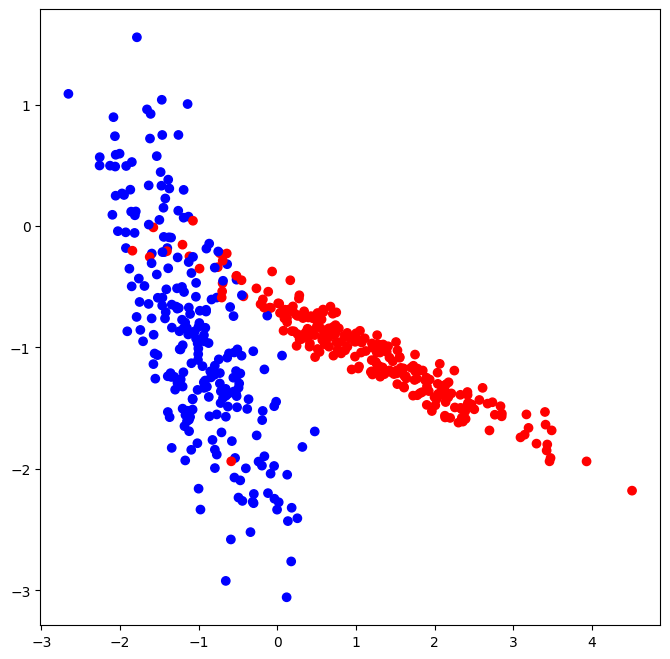

In [2]:
# сгенерируем данные, представляющие собой 500 объектов с 2-мя признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=23)

# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors);

In [3]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    
    bootstrap = []

    for i in range(N):
        sample_indices = np.random.choice(range(n_samples), size=n_samples, replace=True)
        
        b_data = data[sample_indices]
        b_labels = labels[sample_indices]

        bootstrap.append((b_data, b_labels))

    return bootstrap

In [4]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]

    len_subsample = int(np.sqrt(len_sample))
    subsample = []

    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())

    return subsample

In [5]:
# Реализуем класс узла

class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [26]:
# Реализуем класс листа листа

class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels 
        self.prediction = self.predict()

    def predict(self):
        labels_bincount = np.bincount(self.labels)
        prediction = labels_bincount.argmax()
        return prediction

In [46]:
# Расчёт критерия Джини

def gini(labels):
    if not labels:
        return 0

    total_count = len(labels)
    class_counts = {lbl: 0 for lbl in set(labels)}

    for lbl in labels:
        class_counts[lbl] += 1

    impurity = 1.0
    for count in class_counts.values():
        prob = count / total_count
        impurity -= prob * prob

    return impurity

In [47]:
# Расчёт качества

def quality(left_labels, right_labels, current_gini):
    combined_labels = left_labels + right_labels
    total_count = len(combined_labels)
    
    if total_count == 0:
        return 0

    left_weight = len(left_labels) / total_count if total_count > 0 else 0
    right_weight = len(right_labels) / total_count if total_count > 0 else 0

    weighted_gini = left_weight * gini(left_labels) + right_weight * gini(right_labels)

    return current_gini - weighted_gini

In [48]:
# Разбиение выборки на две части

def split(data, labels, index, t):
    true_data, false_data = [], []
    true_labels, false_labels = [], []

    for row, label in zip(data, labels):
        if row[index] >= t:
            true_data.append(row)
            true_labels.append(label)
        else:
            false_data.append(row)
            false_labels.append(label)

    return true_data, false_data, true_labels, false_labels

In [49]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    best_quality = float("inf")
    best_t = None
    best_index = None
#  обозначим минимальное количество объектов в узле
    min_leaf = 5

    n_features = len(data[0])
    
    for index in range(n_features):
        thresholds = set(row[index] for row in data)
        
        for t in thresholds:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            if len(true_labels) < min_leaf or len(false_labels) < min_leaf:
                continue

            total_labels = len(labels)
            true_quality = gini(true_labels) * (len(true_labels) / total_labels)
            false_quality = gini(false_labels) * (len(false_labels) / total_labels)
            current_quality = true_quality + false_quality

            if current_quality < best_quality:
                best_quality = current_quality
                best_t = t
                best_index = index

    return best_quality, best_t, best_index

In [54]:
# Построение дерева посредством рекурсивной функции

def build_tree(data, labels):
    if len(set(labels)) == 1:
        return Leaf(data, labels)

    quality, t, index = find_best_split(data, labels)
    if best_quality == float("inf"):
        return Leaf(data, labels)
        
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
        
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [55]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)

    # Строим лес
    for b_data, b_labels in bootstrap:
        tree = build_tree(b_data, b_labels)
        forest.append(tree)

    return forest

In [56]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):
    while True:
        if isinstance(node, Leaf):
            return node.prediction
        node = node.true_branch if obj[node.index] >= node.t else node.false_branch

In [57]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    predictions = []
    for obj in data:
        predictions.append(classify_object(obj, tree))
    return predictions

In [35]:
# предсказание голосованием деревьев

def tree_vote(forest, data):
    all_predictions = []

    # Получаем предсказания от каждого дерева
    for tree in forest:
        predictions = predict(data, tree)  # Предполагаем, что predict возвращает список предсказаний
        all_predictions.append(predictions)

    # Транспонируем список предсказаний для удобства
    all_predictions = np.array(all_predictions).T

    # Находим наиболее частое предсказание для каждого объекта
    voted_predictions = []
    for predictions in all_predictions:
        # Подсчитываем количество вхождений каждого предсказания
        counts = {}
        for prediction in predictions:
            if prediction in counts:
                counts[prediction] += 1
            else:
                counts[prediction] = 1
        
        # Находим предсказание с максимальным количеством вхождений
        most_common_prediction = max(counts, key=counts.get)
        voted_predictions.append(most_common_prediction)

    return voted_predictions


In [36]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [37]:
  # Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
      if actual[i] == predicted[i]:
        correct += 1
    return correct / float(len(actual)) * 100.0

In [38]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_1, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)
    
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 96.000
Точность случайного леса из 1 деревьев на тестовой выборке: 90.667


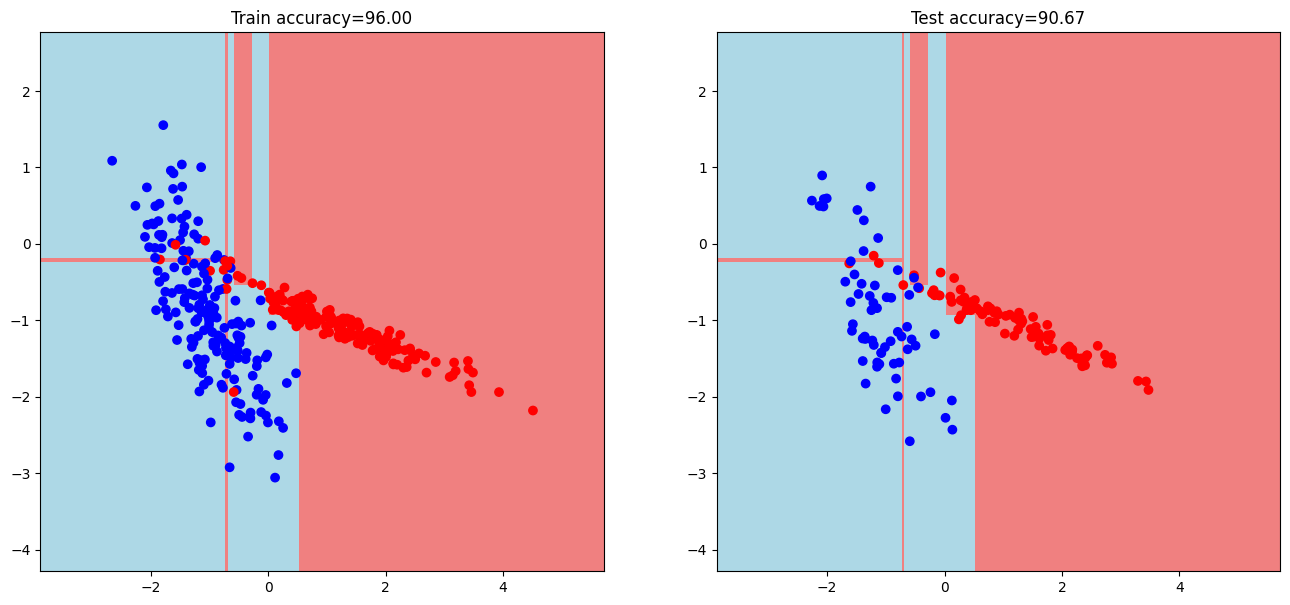

In [39]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()


In [40]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_3, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 99.143
Точность случайного леса из 3 деревьев на тестовой выборке: 92.667


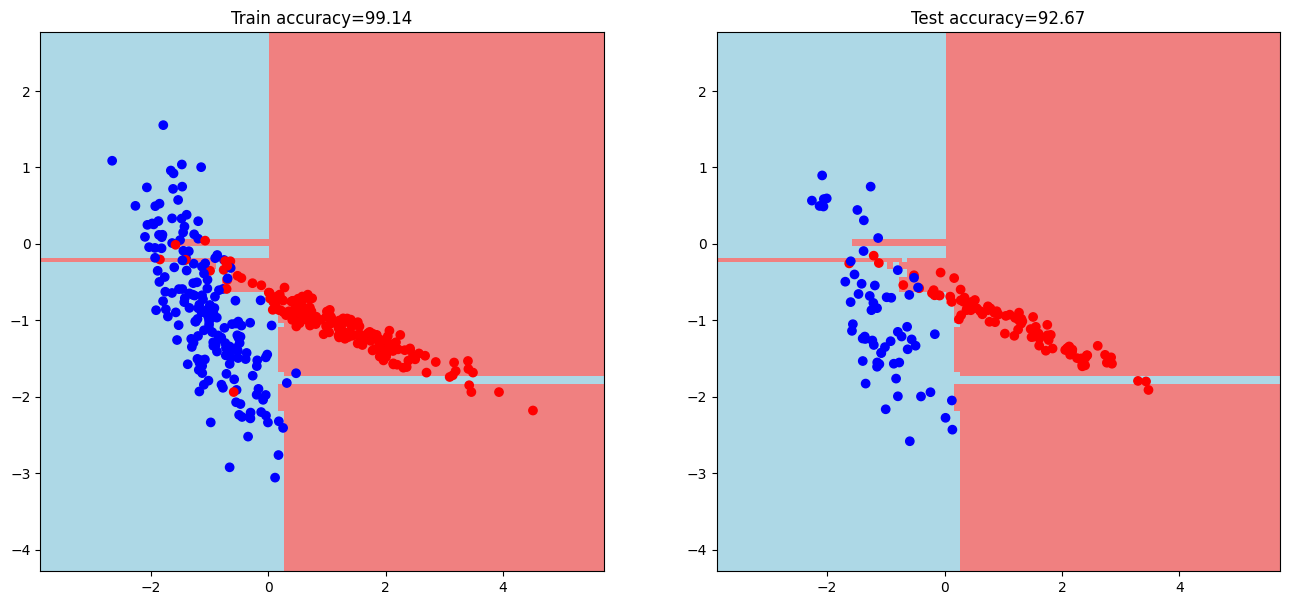

In [41]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()


In [42]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_10, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 99.143
Точность случайного леса из 10 деревьев на тестовой выборке: 92.667


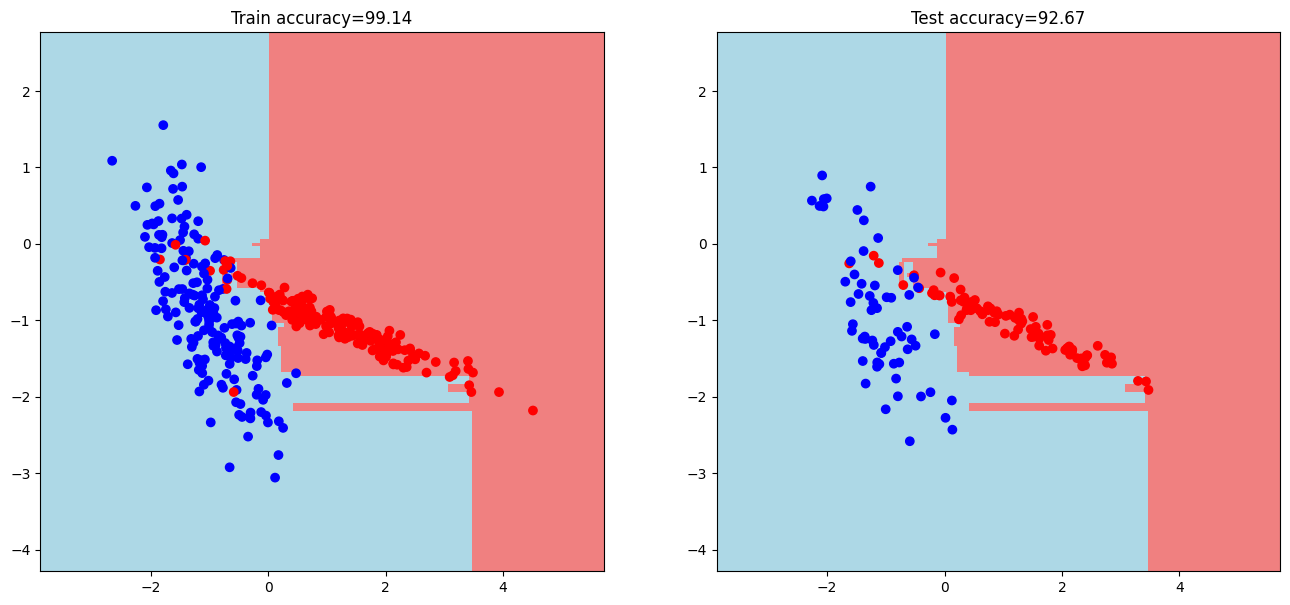

In [43]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()


In [44]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_50, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 93.333


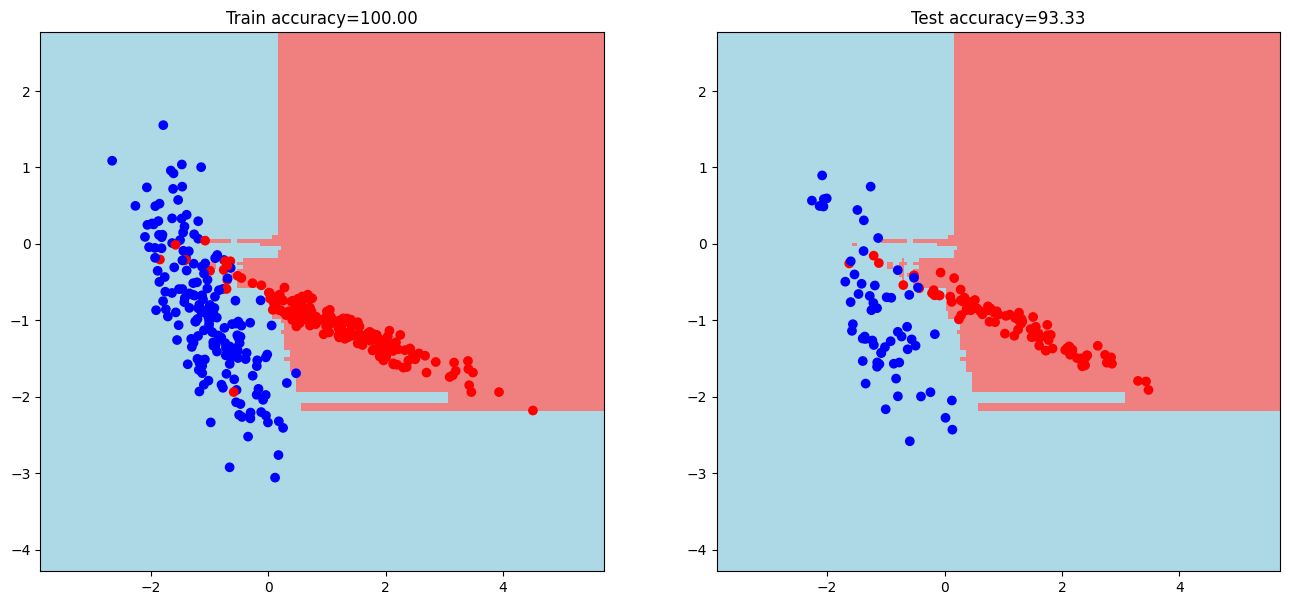

In [45]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_50, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()